# Wine Recommendation Engine

by: Zachary Greenberg

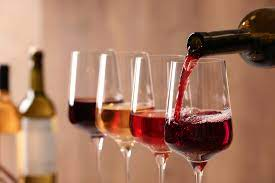

# Overview

The wine industry is gigantic. With extraordinarily large productions of wine comes so many choices. Utilizing Data Science, I intend to give personalized recommendations for wine selection. First, using the provided type of wine as a classifier, I will assess the accuracy of the provided textual reviews in predicting the wine. From here, I will utilize techniques including TF-IDF to vectorize the text and find recommendations based on cosine similarity and euclidean distances.

# Business Understanding

There are so many wines available, so how do you choose? Identifying new wines that are similar to the ones people enjoy can educate them on new bottles and wineries, allowing them to make more informed decisions when choosing their next bottle.

# Data Understanding

The dataset was scraped from Vivino.com. It contains mostly textual data, but some of the data is numeric. Each row is specific to a bottle of wine. It contains the following information:

-*winery*: str, the winery that makes that specific wine  
-*wine_name*: str, the name of the wine  
-*wine_type*: str, the classification of the wine (ie red, white)  
-*wine_country*: str, the country in which the wine was made  
-*average_rating*: float, the average rating of the wine on Vivino.com  
-*num_of_ratings*: int, the number of ratings for that wine on Vivino.com
-*wine_price*: float, the price per bottle  
-*grapes*: str, the grapes utilized in the wine  
-*alcohol_content*: the percent alcohol in the wines  
-*reviews*: str, text reviews of the wine

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
#bringing in the dataframe
df = pd.read_csv('Data/wine_data.csv')

In [3]:
#checking the first 5 rows of the DataFrame
df.head()

,winery,wine_name,wine_type,wine_country,average_rating,num_of_ratings,wine_price,grapes,alcohol_content,reviews
0,Abbazia di Novacella (Stiftskellerei Neustift),Praepositus Kerner 2018,White wine,Italy,4.2,404,31.99,100% Kerner,14.5,"4,2 - Vivino’s rating is also mine. This is a ..."
1,Purulio,Blanco 2016,White wine,Spain,4.2,65,18.00,100% Tempranillo,NaN,A great Orange wine from Andalusia made from 9...
2,Croft,Reserve Tawny Porto N.V.,Fortified Wine,Portugal,4.0,813,19.37,"Tinta Amarela, Tinta Cão, Touriga Nacional, Ti...",NaN,Very good reserve tawny port almost pink in co...
3,Venge Vineyards,Scout's Honor Red 2019,Red wine,United States,4.4,29,35.69,Cabernet Sauvignon,NaN,Just opened the well anticipated delivery! Dar...
4,Smith Woodhouse,10 Year Old Tawny Porto N.V.,Fortified Wine,Portugal,3.8,834,38.00,"Tinta Cão, Touriga Nacional, Tinta Roriz",NaN,My first tawny port! Sweet taste of (sultan) r...


In [4]:
#This is the current size of the dataframe
df.shape

(1200, 10)

In [5]:
#checking for duplicates
sum(df.duplicated())

2

In [6]:
#dropping duplicates
df.drop_duplicates(inplace = True)

In [7]:
#checking the dtypes
df.dtypes

winery              object
wine_name           object
wine_type           object
wine_country        object
average_rating     float64
num_of_ratings       int64
wine_price         float64
grapes              object
alcohol_content    float64
reviews             object
dtype: object

The data are of the correct dtypes.

In [8]:
df.describe()

,average_rating,num_of_ratings,wine_price,alcohol_content
count,1198.000000,1198.000000,1091.000000,281.000000
mean,4.116027,738.483306,26.347938,13.116370
std,0.176885,1784.670618,9.530012,2.909249
min,3.000000,25.000000,9.950000,4.500000
25%,4.000000,61.000000,18.990000,12.500000
50%,4.100000,166.500000,25.990000,13.500000
75%,4.200000,533.000000,32.970000,14.500000
max,4.600000,27106.000000,96.890000,20.500000


Being that ratings are on a scale of 1-5, the average rating is quite high. The range of prices for wines is from 9USD  to 96USD. There seems to be a lot of missing values with alcohol_content. Not all of the entries on Vivino.com had this information readily available.

# Data Cleaning

In [9]:
#changing the name of 'wine_name' to 'wine'
df.rename(columns={'wine_name':'wine'}, inplace = True)

#combining the winery and wine to get the full name of the product and assign it to the index
df['wine_name'] = df['winery'].str.cat(df['wine'], sep = ' ')
df.set_index('wine_name', inplace = True)

In [10]:
#creating a function to remove the year from the 'wine' column
def remove_year_in_name(x):
    '''
    This function removes the year from the 
    wine (name of wine) column.
    '''
    if '18' or '20' in x:
        x = x[:-5]
        return x
    else:
        return x

It seems that the sample of wines generated were either from the 2000s or the 1800s.

In [11]:
#applying the function above
df['wine'] = df['wine'].apply(remove_year_in_name)

In [12]:
df.isnull().sum()

winery               0
wine                 0
wine_type            0
wine_country         1
average_rating       0
num_of_ratings       0
wine_price         107
grapes             307
alcohol_content    917
reviews            266
dtype: int64

This verifies that a little more than half of the entries for alcohol_content are not available. Perhaps the column should be dropped. 

In [13]:
#dropping the alcohol column
df.drop('alcohol_content', axis = 1, inplace = True)

With some of the price variables missing, I am going to impute them with the mean.

In [14]:
#imputing the mean
wine_mean = df.wine_price.mean()

df['wine_price'].fillna(wine_mean, inplace = True)

In [15]:
#dropping the rows with the missing grapes and with that there is only 1 missing review, which I will drop as well
df.dropna(subset = ['grapes', 'reviews'], inplace = True)

In [16]:
#creating a function to fix a capitalization error
def lowercase_W(x):
    """
    This function changes the capitalization error
    in Fortified Wine
    """
    if x == 'Fortified Wine':
        x = 'Fortified wine'
        return x
    else:
        return x

In [17]:
df['wine_type'] = df['wine_type'].apply(lowercase_W)

In [18]:
#changing the wine_type to a single word
conditions = [df['wine_type'] == 'White wine',df['wine_type'] == 'Red wine',
               df['wine_type'] =='Sparkling wine',df['wine_type'] == 'Rosé wine', 
               df['wine_type'] =='Dessert wine', df['wine_type'] =='Fortified wine']
choices = ['White', 'Red', 'Sparkling', 'Rosé', 'Dessert', 'Fortified']

df['wine_type'] = np.select(conditions, choices)

In [19]:
#creating a function to clean the grape column
def clean_grape_column(x):
    '''
    This function cleans the entries in the grape
    column to make all grapes have 
    only 1 name. It removes the '100 %', and it
    also makes any 2 or more grapes in 1 wine 
    as a blend.
    '''
    if ',' in x:
        return 'Blend'
    elif '%' in x:
        return ' '.join(x.split()[1:])
    else:
        return x
    

In [20]:
df['grapes'] = df['grapes'].apply(clean_grape_column)

In [21]:
#changing the Blend to Red, White Blend etc...
types = df['wine_type'].tolist()
grapes = df['grapes'].tolist()

for i, n in enumerate(grapes):
    if grapes[i] == 'Blend':
        grapes[i] = types[i] + ' ' + 'Blend'
        
df['grapes'] = grapes

In [22]:
df.shape

(885, 9)

This dataset now has 885 wines.

# Exploratory Data Analysis

In [23]:
#looking at unique wines
df['winery'].nunique()

632

In [24]:
#looking at the distributon of wine types
df['wine_type'].value_counts()

White        172
Rosé         156
Sparkling    153
Dessert      147
Red          147
Fortified    110
Name: wine_type, dtype: int64

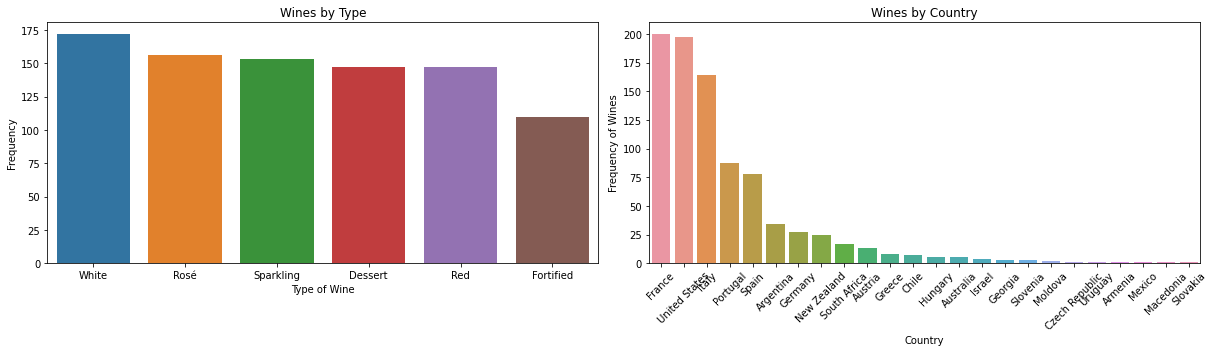

In [25]:
#graphing the distribution of wines by type and country
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

one = sns.barplot(ax=axes[0], x=df['wine_type'].value_counts().index, y=df['wine_type'].value_counts().values)
axes[0].set_title('Wines by Type')
axes[0].set_xlabel('Type of Wine')
axes[0].set_ylabel('Frequency')

two = sns.barplot(ax=axes[1], x=df['wine_country'].value_counts().index, y=df['wine_country'].value_counts().values)
two.set_xticklabels(df['wine_country'].value_counts().index, rotation = 45)
axes[1].set_title('Wines by Country')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Frequency of Wines')

plt.tight_layout()
plt.savefig('Images/wine_graphs.png');

The majority of the wines in this dataset come from the United States. It is not surprising that the two countries that follow are France and Italy. Sparkling wines and Fortified wines seem to be somewhat under represented after filtering through the original dataset.

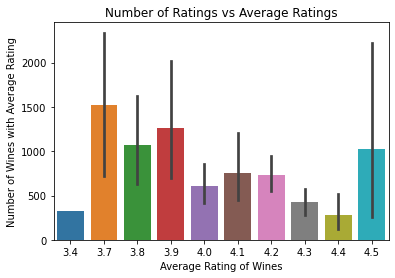

In [26]:
#graphing the ratings data
fig, ax = plt.subplots()
sns.barplot(df['average_rating'], df['num_of_ratings'])
ax.set_xlabel('Average Rating of Wines')
ax.set_ylabel('Number of Wines with Average Rating')
ax.set_title('Number of Ratings vs Average Ratings');

Although the ratings are from 1 - 5, the range of ratings in this dataset are barely larger than 1.0.

In [27]:
df.grapes.value_counts().head()

Rosé Blend         76
Chardonnay         59
Sauvignon Blanc    58
Pinot Noir         55
Fortified Blend    54
Name: grapes, dtype: int64

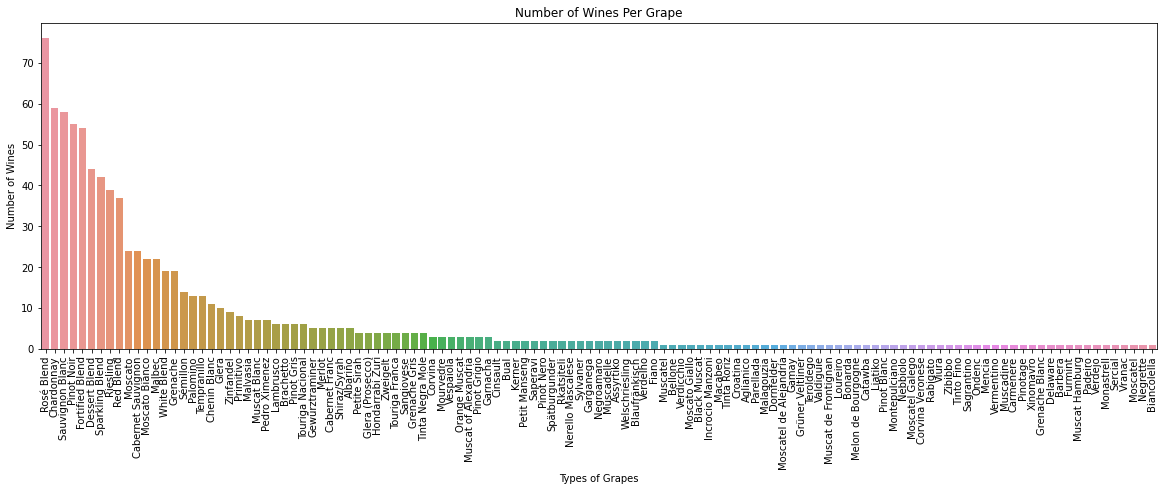

In [28]:
#graphing the number of wines per grape
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(df['grapes'].value_counts().index, df['grapes'].value_counts().values)
ax.set_xlabel('Types of Grapes')
ax.set_ylabel('Number of Wines')
ax.set_xticklabels(df['grapes'].value_counts().index, rotation = 90)
ax.set_title('Number of Wines Per Grape');

Most of the wines in this dataset are Rosé blends.

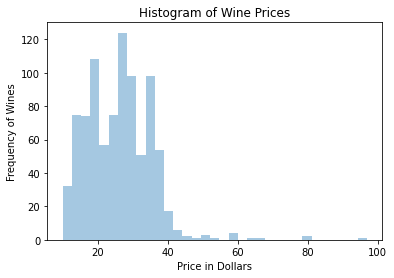

In [29]:
#graphing a histogram of wine prices
fig, ax = plt.subplots()
sns.distplot(df['wine_price'], kde = False)
ax.set_title('Histogram of Wine Prices')
ax.set_xlabel('Price in Dollars')
ax.set_ylabel('Frequency of Wines');

The majority of the wines prices seem to fall around the 25-30 USD mark.

In [30]:
df.groupby('wine_type')['wine_price'].mean().index

Index(['Dessert', 'Fortified', 'Red', 'Rosé', 'Sparkling', 'White'], dtype='object', name='wine_type')

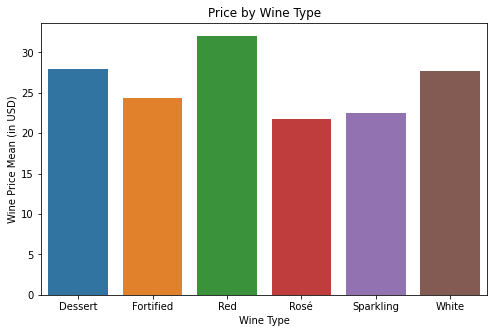

In [31]:
#graphing the price by wine type
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(df.groupby('wine_type')['wine_price'].mean().index, df.groupby('wine_type')['wine_price'].mean().values)
ax.set_xlabel('Wine Type')
ax.set_ylabel('Wine Price Mean (in USD)')
ax.set_title('Price by Wine Type');

It seems that red wine tends to be a bit pricer than others, however, in the scope of things, the difference in average price between the types of wine is not much. 

# Data Preprocessing

Now that I understand the data better, I can move on to preprocessing the reviews using NLP. In this step, I will be adding the grapes and wine types into the stopwords.

In [32]:
#importing NLP libraries
from nltk.corpus import stopwords
from nltk import pos_tag
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [33]:
sw = stopwords.words('english')

In [34]:
#generating the list of stop words
sw = stopwords.words('english') 

#this is a list of grapes lowercased to add to stopwords
wine_string = ','.join(list(df['grapes'].str.lower().unique()))
if ' ' in wine_string:
    wine_string = wine_string.replace(' ', ',')

grape_sw = wine_string.split(',')

#compiling a list of types to add to stop words as well
kind_sw = []

for kind in list(df['wine_type'].unique()):
    kind = kind.lower().replace(' wine', '')
    kind_sw.append(kind)


#adding the grape & kind stop words to the list of all stop words
sw.extend(grape_sw)
sw.extend(kind_sw)

#adding additional words in as well that are unnecessary:
unnecessary_words = ['good', 'nice', 'smell', 'taste', 'mouth', 
                     'nose', 'great', 'note', 'finish', 'tannin', 
                     'wine', 'like', 'palate', 'aroma', 'one', 'hint',
                    'well', 'long', 'ro', 'flavor', 'lovely']
sw.extend(unnecessary_words)

In [35]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [36]:
def text_preparer(doc, stopwords=sw):
    '''
    This function takes in a document, and a list of
    stop words. It prepares the text by lowercasing the 
    elements, removing numbers and punctuation, and 
    lemmatizes
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    #The lemmatizer wants to know what to look for:
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [37]:
#parsing the review text 
df['token_reviews'] = df['reviews'].apply(text_preparer)

In [38]:
#getting the groups together to make word clouds
White = df[df['wine_type'] == 'White']['token_reviews'].values.tolist()
Red = df[df['wine_type'] == 'Red']['token_reviews'].values.tolist()
Sparkling = df[df['wine_type'] == 'Sparkling']['token_reviews'].values.tolist()
Fortified = df[df['wine_type'] == 'Fortified']['token_reviews'].values.tolist()
Dessert = df[df['wine_type'] == 'Dessert']['token_reviews'].values.tolist()
Rosé = df[df['wine_type'] == 'Rosé']['token_reviews'].values.tolist()
texts = [White, Red, Sparkling, Fortified, Dessert, Rosé]
labels = ['White', 'Red', 'Sparkling', 'Fortified', 'Dessert', 'Rosé']

In [39]:
from wordcloud import WordCloud

def show_wordcloud(data, labels):
    """
    This function takes a list of text data
    (also in list form) along with a list of
    labels and returns a word cloud.
    """
    i = 0
    for group in data:
        wordcloud = WordCloud(
            background_color='black',
            stopwords=sw,
            max_words=30, 
            scale=3,
            random_state=12
        ).generate(str(group))

        fig = plt.figure(1, figsize=(6, 6))
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(wordcloud)
        plt.show()
        i+=1

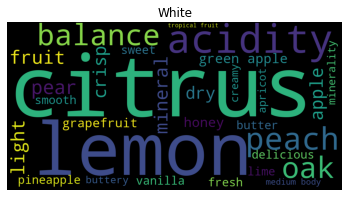

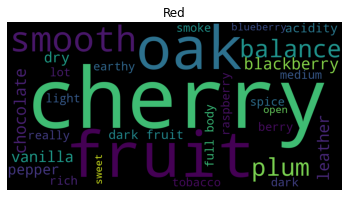

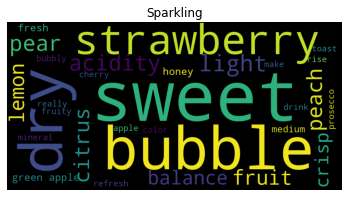

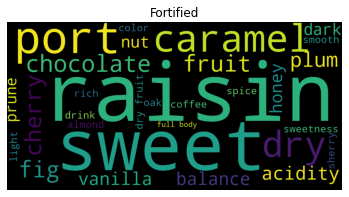

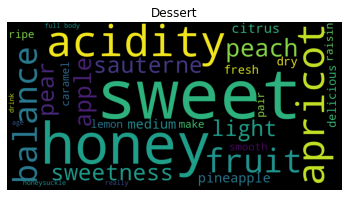

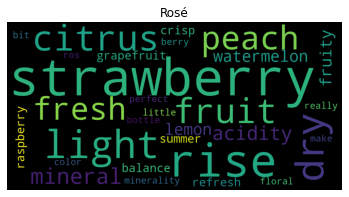

In [40]:
#generating word clouds for each of the wine types
show_wordcloud(texts, labels)

In [41]:
#getting dummy columns for the categorical variables
dummy_columns = ['wine_country', 'grapes']

df_model = pd.get_dummies(df, columns = dummy_columns)

# Modeling

## Random Forest for Wine Classification based on Review Text

As a form of supervised learning, and a clarity check, I am going to perform a MultiNomial Naive Bayes algorithm on the text reviews and assess their accuracy on identifying the type of wine in the 'wine_types' column.

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X = df['reviews']
y = df['wine_type']

In [44]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 13)

In [45]:
len(X_train), len(X_test), len(y_train), len(y_test)

(708, 177, 708, 177)

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
accuracy = make_scorer(accuracy_score)

pipeline = Pipeline([
                    ('tv', TfidfVectorizer()),
                    ('rf', RandomForestClassifier(random_state=42))
                    ])


rf_param_grid_pipe = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_depth": [None, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16],
    "rf__max_features": [None,4,5,6,9,10],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf" : [1, 2, 3, 5, 6],
    "rf__n_estimators" : [10, 30, 100]
}


grid_search_pipe = GridSearchCV(pipeline, rf_param_grid_pipe, cv=3, verbose=1, n_jobs=-1, scoring = accuracy)

grid_search_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 5940 candidates, totalling 17820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tv', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [None, 2, 3, 4, 5, 6, 8, 10, 12, 14,
                                           16],
                         'rf__max_features': [None, 4, 5, 6, 9, 10],
                         'rf__min_samples_leaf': [1, 2, 3, 5, 6],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [10, 30, 100]},
             scoring=make_scorer(accuracy_score), verbose=1)

In [47]:
print(grid_search_pipe.best_params_)

{'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 9, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}


In [48]:
grid_search_pipe.score(X_test, y_test)

0.7627118644067796

In [49]:
from sklearn.naive_bayes import MultinomialNB

mb = Pipeline([
                    ('tv', TfidfVectorizer()),
                    ('mb', MultinomialNB())
                    ])

param_grid_pipe = {
    "mb__alpha": [1, .5, .25, .75],
    
}


grid_search_pipe = GridSearchCV(mb, param_grid_pipe, cv=3, verbose=1, n_jobs=-1, scoring=accuracy)
grid_search_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tv', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1, param_grid={'mb__alpha': [1, 0.5, 0.25, 0.75]},
             scoring=make_scorer(accuracy_score), verbose=1)

In [50]:
print(grid_search_pipe.best_params_)

{'mb__alpha': 0.25}


In [51]:
grid_search_pipe.score(X_test, y_test)

0.8022598870056498

When comparing the two algorithms, the Multinomial Bayes gave a higher accuracy score. I will now run a model with those parameters to look at the confusion matrix.

In [52]:
mb = Pipeline([
                    ('tv', TfidfVectorizer()),
                    ('mb', MultinomialNB(alpha = .25))
                    ])

mb.fit(X_train, y_train)

Pipeline(steps=[('tv', TfidfVectorizer()), ('mb', MultinomialNB(alpha=0.25))])

In [53]:
y_pred_mb = mb.predict(X_test)

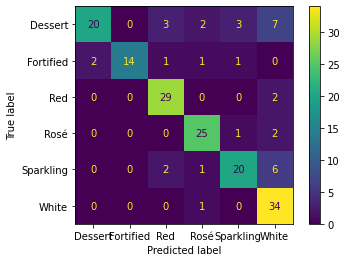

In [54]:
from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(mb,y_pred_mb, y_test)
plt.savefig('Images/Matrix.png');

In [55]:
from sklearn.metrics import plot_confusion_matrix, classification_report
print(classification_report(y_test, y_pred_mb))

              precision    recall  f1-score   support

     Dessert       0.91      0.57      0.70        35
   Fortified       1.00      0.74      0.85        19
         Red       0.83      0.94      0.88        31
        Rosé       0.83      0.89      0.86        28
   Sparkling       0.80      0.69      0.74        29
       White       0.67      0.97      0.79        35

    accuracy                           0.80       177
   macro avg       0.84      0.80      0.80       177
weighted avg       0.83      0.80      0.80       177



The reviews show an 80% accuracy of identifying the types of wine. This shows that the reviews can be helpful in making recommendations. 

## Cosine Similarity

Before I create my rec system, I will use TFIDF to vectorize my text reviews, merge the array to the DataFrame, and scale: 

In [56]:
#vectorizing text reviews
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvec = TfidfVectorizer(tokenizer = text_preparer)
tf_idfwine = tfidfvec.fit_transform((df_model['token_reviews']))

In [57]:
df_tfidf = pd.DataFrame(tf_idfwine.toarray())

In [58]:
#dropping unnecessary columns from the df_model DataFrame
model_data = df_model.drop(labels = ['winery', 'wine', 'wine_type', 'reviews', 'token_reviews'], axis = 1)
model_data = pd.concat([model_data.reset_index(), df_tfidf], axis = 1)

#setting the wine as the index
model_data = model_data.set_index('wine_name')

In [59]:
model_data.columns[:3] #aside from the dummy variables and vectorized columns, these are the other ones in the model

Index(['average_rating', 'num_of_ratings', 'wine_price'], dtype='object')

In [60]:
#scaling the new matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(model_data)

scale_model_data = pd.DataFrame(scaler.transform(model_data), columns = model_data.columns, index = model_data.index)

In [61]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(scale_model_data, scale_model_data)

In [62]:
# Storing indices of the data
indices = pd.Series(df.index)
  
def cosine_recommendations(wine, cos_sim):
    """
    This function takes in a wine from the index along 
    with the cosine distance array, and returns the 
    top 10 wines with the highest similarity.
    """
    recommended_wines = []
    index = indices[indices == wine].index[0]
    similarity_scores = pd.Series(cos_sim[index]).sort_values(ascending = False)
    top_10_wines = list(similarity_scores.iloc[1:11].index)
    for i in top_10_wines:
        recommended_wines.append(list(df_model.index)[i])
        matches = df.loc[recommended_wines][['wine_type', 'wine_country', 'average_rating', 'wine_price']]
    matches['similarity_scores'] = list(similarity_scores.iloc[1:11].values)
    return matches
        

In [63]:
print('Cosine Similarity Model')
cosine_recommendations("Domaine du Salvard Cheverny Rosé 2016", cos_sim)

Cosine Similarity Model


,wine_type,wine_country,average_rating,wine_price,similarity_scores
wine_name,,,,,
Jean-Luc Colombo Cape Bleue Rosé 2019,Rosé,France,3.9,13.24,0.791307
Domaine Le Galantin Bandol Rosé 2019,Rosé,France,4.1,21.95,0.685193
Château d'Esclans The Palm Whispering Angel Rosé 2019,Rosé,France,3.9,15.99,0.678525
Commanderie de la Bargemone Rosé 2019,Rosé,France,4.1,16.99,0.670716
Château d'Esclans The Palm Whispering Angel Rosé 2018,Rosé,France,3.9,18.99,0.669493
Château Castel des Maures Cuvée Jeanne Côtes de Provence Rosé 2019,Rosé,France,3.9,24.99,0.663626
Domaine de la Mordorée La Reine des Bois Tavel Rosé 2018,Rosé,France,4.0,29.99,0.654338
Château de Berne Château de Berne Rosé 2018,Rosé,France,3.9,18.99,0.638382
Domaines Bunan Mas de la Rouvière Rosé 2019,Rosé,France,4.0,27.99,0.634574


## Euclidean Distance

In [64]:
from sklearn.metrics.pairwise import euclidean_distances

euc_dist = euclidean_distances(scale_model_data, scale_model_data)

In [65]:
# Storing indices of the data
indices = pd.Series(df.index)
  
def euclidean_recommendations(wine, euc_dist):
    """
    This function takes in a wine from the index along 
    with the euclidean distance array, and returns the 
    top 10 wines with the highest similarity.
    """
    recommended_wines = []
    index = indices[indices == wine].index[0]
    similarity_scores = pd.Series(euc_dist[index]).sort_values(ascending = True)
    top_10_wines = list(similarity_scores.iloc[1:11].index)
    for i in top_10_wines:
        recommended_wines.append(list(df_model.index)[i])
        matches = df.loc[recommended_wines][['wine_type', 'wine_country', 'average_rating', 'wine_price']]
    matches['similarity_scores'] = list(similarity_scores.iloc[1:11].values)
    return matches
        

In [66]:
print('Euclidean Distance Model')
euclidean_recommendations("Domaine du Salvard Cheverny Rosé 2016", euc_dist)

Euclidean Distance Model


,wine_type,wine_country,average_rating,wine_price,similarity_scores
wine_name,,,,,
Jean-Luc Colombo Cape Bleue Rosé 2019,Rosé,France,3.9,13.24,3.951515
Domaine Le Galantin Bandol Rosé 2019,Rosé,France,4.1,21.95,4.619491
Domaine de la Mordorée La Reine des Bois Tavel Rosé 2018,Rosé,France,4.0,29.99,4.705292
Château d'Esclans The Palm Whispering Angel Rosé 2019,Rosé,France,3.9,15.99,4.729992
Commanderie de la Bargemone Rosé 2019,Rosé,France,4.1,16.99,4.822727
Domaines Bunan Mas de la Rouvière Rosé 2019,Rosé,France,4.0,27.99,4.921169
Château de Berne Château de Berne Rosé 2018,Rosé,France,3.9,18.99,4.934054
Château Castel des Maures Cuvée Jeanne Côtes de Provence Rosé 2019,Rosé,France,3.9,24.99,4.970012
Château d'Esclans The Palm Whispering Angel Rosé 2018,Rosé,France,3.9,18.99,5.104442


# Evaluation

The results of my content based recommendation systems, created using the cosine similarity and euclidean distancing metrics, are more subject to opinion. I will say that I had a few friends try this out, who are avid wine drinkers, and they did feel that the output of the with Euclidean distance seemed a bit more logical. I am assured having performed classification algorithms on the review text, and achieving the accuracy results I did. 